In [1]:
%load_ext dotenv
%dotenv 
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
from utils.logger import get_logger
_logs = get_logger(__name__)

In [2]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
from glob import glob

In [3]:
ft_dir = os.getenv("FEATURES_DATA")
ft_glob = glob(os.path.join(ft_dir, '**/*.parquet'), 
               recursive = True)
df = dd.read_parquet(ft_glob).compute().reset_index()

# Sampling in Python

+ There are different packages that allow sampling.
+ A practical approach is to use pandas/Dask sampling methods.

## Random Sampling

+ Sample n rows from a dataframe with [`df.sample()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html).

```
DataFrame.sample(
    n=None, frac=None, replace=False, weights=None, 
    random_state=None, axis=None, ignore_index=False
    )
```

In [4]:
df.sample(n = 5)

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,source,Year,Close_lag_1
176724,LIVE,2003-06-24,116.000000,120.000000,110.000000,120.000000,115.822517,0.0,LIVE.csv,2003,120.000000
56882,AXP,1983-09-14,4.988754,4.988754,4.892198,4.988754,0.732987,3191500.0,AXP.csv,1983,4.956569
53357,AXP,1977-12-20,2.333450,2.333450,2.301264,2.317357,0.261248,1762300.0,AXP.csv,1977,2.333450
142773,IBDT,2019-08-01,26.889999,28.320000,26.889999,27.350000,26.820171,10400.0,IBDT.csv,2019,27.150000
240885,QLYS,2014-10-09,28.549999,28.990000,27.900000,28.340000,28.340000,271300.0,QLYS.csv,2014,28.520000


In [5]:
import random
random.seed(42)
sample_tickers = random.sample(df['ticker'].unique().tolist(), 30)
df = df[df['ticker'].isin(sample_tickers)]
simple_sample_dt = df.sample(frac = 0.1)
simple_sample_dt.shape, df.shape

((14070, 11), (140698, 11))

Look at the distribution of tickers.

<Axes: xlabel='ticker'>

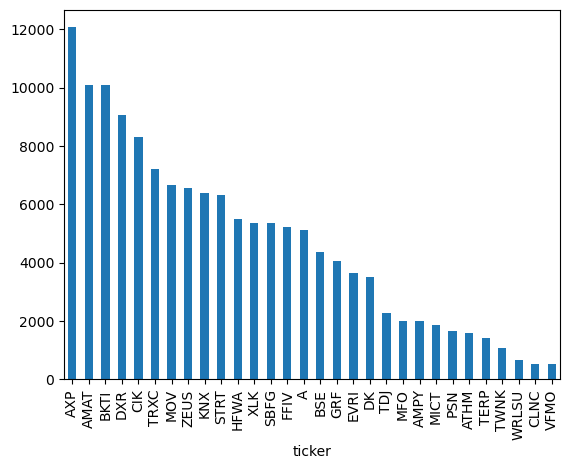

In [6]:
df['ticker'].value_counts().plot(kind='bar')

<Axes: xlabel='ticker'>

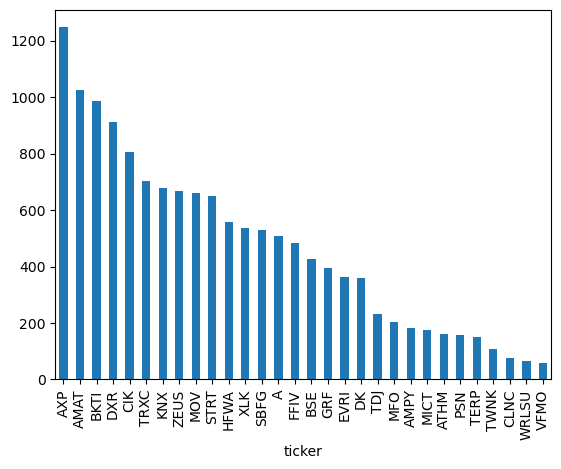

In [7]:
simple_sample_dt['ticker'].value_counts().plot(kind='bar')

## Stratified Sampling

+ Use `groupby()` and `.sample()` for stratified sampling.

<Axes: xlabel='ticker'>

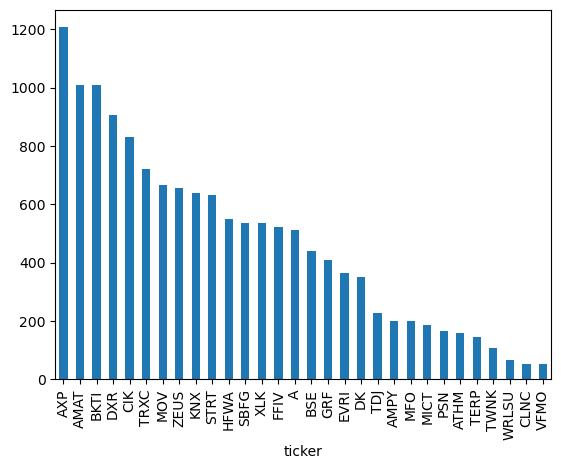

In [8]:
strat_sample_dt = df.groupby(['ticker']).sample(frac = 0.1)
strat_sample_dt['ticker'].value_counts().plot(kind='bar')

# Sampling in Dask

+ Stratified sampling in `dask` can be achieved with `groupby().apply()` and a lambda function.

/var/folders/nb/8xqrwtxj0g38cgj_rm5pgfvr0000gn/T/ipykernel_76616/1783207470.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  strat_sample_dd = (dd_dt


<Axes: xlabel='ticker'>

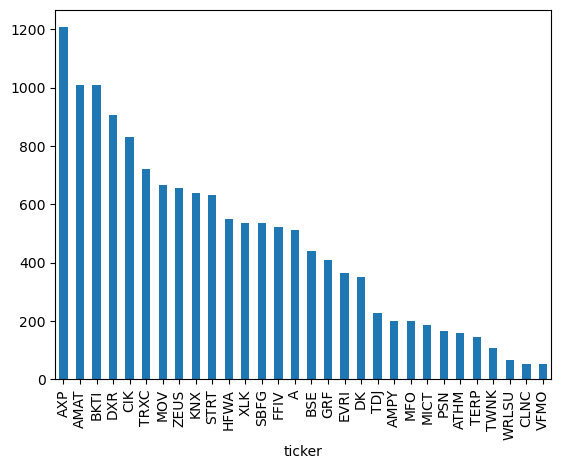

In [9]:
dd_dt = dd.read_parquet(ft_glob)
strat_sample_dd = (dd_dt
                      .groupby('ticker', group_keys=False)
                      .apply(lambda x: x.sample(frac = 0.1))
                      .compute()
                      .reset_index())
strat_sample_dd[strat_sample_dd['ticker'].isin(sample_tickers)]['ticker'].value_counts().plot(kind='bar')